[View in Colaboratory](https://colab.research.google.com/github/iegorval/neural_nets/blob/master/CorrectedBinary.ipynb)

# Getting Ready
Prepare the files and the libraries for the experiment.

In [1]:
# Installs
!pip install -U -q PyDrive

In [2]:
# Imports
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import LSTM, Input, Activation, Dense, TimeDistributed, Dropout, BatchNormalization
from keras.models import Sequential
from keras import optimizers
from keras.callbacks import Callback, LearningRateScheduler
import keras.backend as K
import keras.utils as utils
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import re
from io import StringIO
from math import exp

Using TensorFlow backend.


In [3]:
# PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# Get all files from the root folder
file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()

In [4]:
# Get the .pow files 
pow_files = [(file['title'], file['id'], re.sub(r'_[0-9]+|.pow', '', file['title'])) 
             for file in file_list if file['title'].find('.pow')>0]
num_examples = len(pow_files)
# Get the categories
categories = list(set([file_info[2] for file_info in pow_files]))
# Get the dictionary of the categories
num_cat = len(categories)
categories_dict = {categories[i] : i for i in range(num_cat)}

In [5]:
print(categories_dict)

{'grass_flat': 0, 'flat': 1, 'black_flat': 2, 'black_rough': 3, 'cubes': 4, 'grass_rough': 5}


# Utils
Helper functions.

In [6]:
def to_one_hot(category):
  assert category < num_cat
  one_hot = np.zeros((num_cat))
  one_hot[category] = 1
  return one_hot

In [7]:
def from_one_hot(one_hot):
  for i in range(len(one_hot)):
    if one_hot[i]==1:
      return i

# Model
Recurrent Neural Network model in Keras.

In [8]:
def get_model1():
  model = Sequential()
  model.add(LSTM(32, return_sequences=False, input_shape=(max_length//skip,1)))
  model.add(Dense(1))
  model.add(Activation("sigmoid"))
  return model

In [9]:
def get_model2():
  model = Sequential()
  model.add(LSTM(64, return_sequences=False, input_shape=(max_length//skip,1)))
  model.add(Dense(1))
  model.add(Activation("sigmoid"))
  return model

In [10]:
def get_model3():
  model = Sequential()
  model.add(LSTM(32, return_sequences=True, input_shape=(max_length//skip,1)))
  model.add(LSTM(32))
  model.add(Dense(1))
  model.add(Activation("sigmoid"))
  return model

In [11]:
def get_model4():
  model = Sequential()
  model.add(LSTM(64, return_sequences=True, input_shape=(max_length//skip,1)))
  model.add(LSTM(64))
  model.add(Dense(1))
  model.add(Activation("sigmoid"))
  return model

In [13]:
def get_model5():
  model = Sequential()
  model.add(LSTM(32, return_sequences=True, input_shape=(max_length//skip,1)))
  model.add(Dropout(0.4))
  model.add(LSTM(32))
  model.add(Dropout(0.4))
  model.add(Dense(1))
  model.add(Activation("sigmoid"))
  return model

In [14]:
def get_model6():
  model = Sequential()
  model.add(LSTM(64, return_sequences=True, input_shape=(max_length//skip,1)))
  model.add(Dropout(0.4))
  model.add(LSTM(64))
  model.add(Dropout(0.4))
  model.add(Dense(1))
  model.add(Activation("sigmoid"))
  return model

# Data
Preprocess the data: combine all the examples together and introduce padding where necessary. Split the longest time series in the several smaller ones.

In [15]:
# Make a list of dataframes along with their corresponding classes
list_df = list()
for pow_file in pow_files:
  if pow_file[0].find('cubes')==0 or pow_file[0].find('flat')==0:
    f = drive.CreateFile({'id': pow_file[1]})
    content = f.GetContentString()
    dataIO = StringIO(content)
    df = pd.read_csv(dataIO, header=None, sep=' ')
    list_df.append((df, to_one_hot(categories_dict[pow_file[2]])))

In [16]:
# Make a list of dataframes along with their corresponding classes
list_df = list()
for pow_file in pow_files:
  if pow_file[0].find('black_rough')==0 or pow_file[0].find('grass_rough')==0 \
     or pow_file[0].find('black_flat')==0 or pow_file[0].find('grass_flat')==0:
    f = drive.CreateFile({'id': pow_file[1]})
    content = f.GetContentString()
    dataIO = StringIO(content)
    df = pd.read_csv(dataIO, header=None, sep=' ')
    list_df.append((df, to_one_hot(categories_dict[pow_file[2]])))

In [17]:
# Split the biggest examples into separate sequences
max_length = 100
long_dfs = [i for i in range(len(list_df)) if list_df[i][0].shape[0] > max_length]
list_df_cut = list(list_df)
max_examples = 3000
examples_categories = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
for i in reversed(long_dfs):
  df = list_df_cut[i][0]
  category = from_one_hot(list_df_cut[i][1])
  for g, split_df in df.groupby(np.arange(len(df)) // max_length):
    if examples_categories[category] < max_examples:
      list_df_cut.append((split_df, list_df[i][1]))
      examples_categories[category] += 1
  del list_df_cut[i]

In [18]:
print(examples_categories)
print(categories_dict)

{0: 179, 1: 0, 2: 112, 3: 215, 4: 0, 5: 161}
{'grass_flat': 0, 'flat': 1, 'black_flat': 2, 'black_rough': 3, 'cubes': 4, 'grass_rough': 5}


In [19]:
# Get only the measurements for current
currents_list = [(np.transpose(np.array(df_cut[0][[2]])), df_cut[1]) for df_cut in list_df_cut]
currents_long = [(np.transpose(currents[0]), currents[1]) for currents in currents_list if currents[0].shape[1]>=max_length]
currents_no_labels = [currents[0] for currents in currents_long]

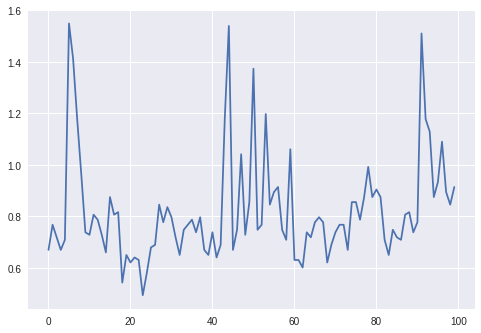

In [20]:
plt.plot(currents_no_labels[0])

In [38]:
# Skip some timesteps
skip = 1
currents_skip = list()
for currents in currents_no_labels:
  currents_skip.append(list())
  i = 0
  while True:
    currents_skip[-1].append(currents[i])
    i += skip
    if i >= len(currents):
      break

In [64]:
# Get training data into a numpy matrix
full_x = np.stack(currents_skip, axis=0)
# Get training labels
full_y = np.array([currents[1] for currents in currents_long])

In [60]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [65]:
full_x_norm = utils.normalize(full_x, axis=0, order=2)
x_shuffled, y_shuffled = unison_shuffled_copies(full_x_norm, full_y)

In [66]:
full_y_labels = [from_one_hot(one_hot) for one_hot in y_shuffled]
full_y_binary = [0 if label==categories_dict['black_flat'] or label==categories_dict['black_rough'] else 1 for label in full_y_labels]

In [67]:
print(full_x_norm.shape, x_shuffled.shape)
print(full_y.shape, y_shuffled.shape)

(655, 100, 1) (655, 100, 1)
(655, 6) (655, 6)


[0. 0. 1. 0. 0. 0.]


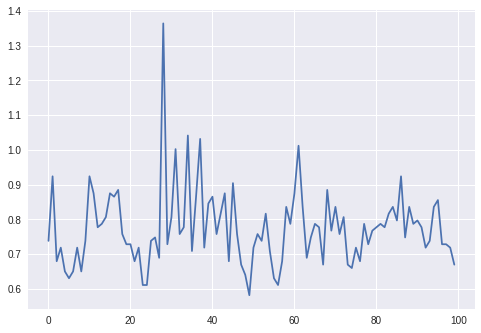

In [68]:
# Training set
train_x = x_shuffled[130:]
train_y = y_shuffled[130:]
# Test set
test_x = x_shuffled[:130]
test_y = y_shuffled[:130]


plt.plot(full_x[1])
print(full_y[1])

# Experiment

In [69]:
model = get_model1()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
_________________________________________________________________
activation_5 (Activation)    (None, 1)                 0         
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [47]:
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
rmsprop = optimizers.RMSprop(lr=0.00001, rho=0.9, epsilon=None, decay=0.0)

In [48]:
def exp_decay(epoch):
    initial_lrate = 0.01
    k = 0.1
    lrate = initial_lrate * exp(-k*epoch)
    return lrate
lrate = LearningRateScheduler(exp_decay)
callbacks_list = [lrate]

In [49]:
model.compile(loss='binary_crossentropy', optimizer=rmsprop, metrics=['accuracy'])

In [50]:
history = model.fit(train_x, train_y, epochs=200, batch_size=16, shuffle=True, callbacks=callbacks_list, verbose=2)

Epoch 1/200
 - 50s - loss: 0.7597 - acc: 0.5186
Epoch 2/200
 - 28s - loss: 0.6954 - acc: 0.5221
Epoch 3/200
 - 29s - loss: 0.6922 - acc: 0.5327
Epoch 4/200
 - 29s - loss: 0.6981 - acc: 0.5345
Epoch 5/200
 - 27s - loss: 0.6923 - acc: 0.5416
Epoch 6/200
 - 27s - loss: 0.6941 - acc: 0.5381
Epoch 7/200
 - 27s - loss: 0.6933 - acc: 0.5469
Epoch 8/200
 - 27s - loss: 0.6879 - acc: 0.5504
Epoch 9/200
 - 26s - loss: 0.7065 - acc: 0.5186
Epoch 10/200
 - 27s - loss: 0.6987 - acc: 0.5221
Epoch 11/200
 - 26s - loss: 0.6933 - acc: 0.5451
Epoch 12/200
 - 27s - loss: 0.6961 - acc: 0.5292
Epoch 13/200
 - 28s - loss: 0.7487 - acc: 0.5062
Epoch 14/200
 - 28s - loss: 0.6857 - acc: 0.5469
Epoch 15/200
 - 29s - loss: 0.6980 - acc: 0.5133
Epoch 16/200
 - 30s - loss: 0.6914 - acc: 0.5381
Epoch 17/200
 - 30s - loss: 0.6973 - acc: 0.5221
Epoch 18/200
 - 30s - loss: 0.6957 - acc: 0.5292
Epoch 19/200
 - 31s - loss: 0.6939 - acc: 0.5204
Epoch 20/200
 - 31s - loss: 0.6944 - acc: 0.5274
Epoch 21/200
 - 31s - loss: 0

Epoch 46/200
 - 30s - loss: 0.6375 - acc: 0.6142
Epoch 47/200
 - 30s - loss: 0.6375 - acc: 0.6142
Epoch 48/200
 - 30s - loss: 0.6370 - acc: 0.6142
Epoch 49/200
 - 29s - loss: 0.6371 - acc: 0.6142
Epoch 50/200
 - 31s - loss: 0.6367 - acc: 0.6142
Epoch 51/200
 - 30s - loss: 0.6368 - acc: 0.6142
Epoch 52/200
 - 30s - loss: 0.6361 - acc: 0.6142
Epoch 53/200
 - 30s - loss: 0.6362 - acc: 0.6142
Epoch 54/200
 - 31s - loss: 0.6361 - acc: 0.6142
Epoch 55/200
 - 32s - loss: 0.6359 - acc: 0.6142
Epoch 56/200
 - 32s - loss: 0.6359 - acc: 0.6142
Epoch 57/200
 - 33s - loss: 0.6357 - acc: 0.6142
Epoch 58/200
 - 32s - loss: 0.6358 - acc: 0.6142
Epoch 59/200
 - 32s - loss: 0.6356 - acc: 0.6142
Epoch 60/200
 - 32s - loss: 0.6355 - acc: 0.6142
Epoch 61/200
 - 32s - loss: 0.6355 - acc: 0.6142
Epoch 62/200
 - 31s - loss: 0.6354 - acc: 0.6142
Epoch 63/200
 - 33s - loss: 0.6353 - acc: 0.6142
Epoch 64/200
 - 33s - loss: 0.6353 - acc: 0.6142
Epoch 65/200
 - 33s - loss: 0.6352 - acc: 0.6142
Epoch 66/200
 - 33s 

Epoch 91/200
 - 30s - loss: 0.6347 - acc: 0.6124
Epoch 92/200
 - 30s - loss: 0.6347 - acc: 0.6124
Epoch 93/200
 - 30s - loss: 0.6347 - acc: 0.6124
Epoch 94/200
 - 29s - loss: 0.6347 - acc: 0.6124
Epoch 95/200
 - 29s - loss: 0.6347 - acc: 0.6124
Epoch 96/200
 - 28s - loss: 0.6347 - acc: 0.6124
Epoch 97/200
 - 30s - loss: 0.6347 - acc: 0.6124
Epoch 98/200
 - 28s - loss: 0.6347 - acc: 0.6124
Epoch 99/200
 - 27s - loss: 0.6347 - acc: 0.6124
Epoch 100/200
 - 26s - loss: 0.6347 - acc: 0.6124
Epoch 101/200
 - 27s - loss: 0.6346 - acc: 0.6124
Epoch 102/200
 - 28s - loss: 0.6346 - acc: 0.6124
Epoch 103/200
 - 28s - loss: 0.6346 - acc: 0.6124
Epoch 104/200
 - 27s - loss: 0.6346 - acc: 0.6124
Epoch 105/200
 - 28s - loss: 0.6346 - acc: 0.6124
Epoch 106/200
 - 29s - loss: 0.6346 - acc: 0.6124
Epoch 107/200
 - 29s - loss: 0.6346 - acc: 0.6124
Epoch 108/200
 - 28s - loss: 0.6346 - acc: 0.6124
Epoch 109/200
 - 28s - loss: 0.6346 - acc: 0.6124
Epoch 110/200
 - 29s - loss: 0.6346 - acc: 0.6124
Epoch 111

 - 30s - loss: 0.6346 - acc: 0.6124
Epoch 136/200
 - 30s - loss: 0.6346 - acc: 0.6124
Epoch 137/200
 - 29s - loss: 0.6346 - acc: 0.6124
Epoch 138/200
 - 27s - loss: 0.6346 - acc: 0.6124
Epoch 139/200
 - 29s - loss: 0.6346 - acc: 0.6124
Epoch 140/200
 - 28s - loss: 0.6346 - acc: 0.6124
Epoch 141/200
 - 27s - loss: 0.6346 - acc: 0.6124
Epoch 142/200
 - 26s - loss: 0.6346 - acc: 0.6124
Epoch 143/200
 - 26s - loss: 0.6346 - acc: 0.6124
Epoch 144/200
 - 26s - loss: 0.6346 - acc: 0.6124
Epoch 145/200
 - 26s - loss: 0.6346 - acc: 0.6124
Epoch 146/200
 - 27s - loss: 0.6346 - acc: 0.6124
Epoch 147/200
 - 27s - loss: 0.6346 - acc: 0.6124
Epoch 148/200
 - 28s - loss: 0.6346 - acc: 0.6124
Epoch 149/200
 - 27s - loss: 0.6346 - acc: 0.6124
Epoch 150/200
 - 26s - loss: 0.6346 - acc: 0.6124
Epoch 151/200
 - 26s - loss: 0.6346 - acc: 0.6124
Epoch 152/200
 - 28s - loss: 0.6346 - acc: 0.6124
Epoch 153/200
 - 27s - loss: 0.6346 - acc: 0.6124
Epoch 154/200
 - 28s - loss: 0.6346 - acc: 0.6124
Epoch 155/200


 - 28s - loss: 0.6346 - acc: 0.6124
Epoch 180/200
 - 26s - loss: 0.6346 - acc: 0.6124
Epoch 181/200
 - 26s - loss: 0.6346 - acc: 0.6124
Epoch 182/200
 - 25s - loss: 0.6346 - acc: 0.6124
Epoch 183/200
 - 27s - loss: 0.6346 - acc: 0.6124
Epoch 184/200
 - 27s - loss: 0.6346 - acc: 0.6124
Epoch 185/200
 - 26s - loss: 0.6346 - acc: 0.6124
Epoch 186/200
 - 27s - loss: 0.6346 - acc: 0.6124
Epoch 187/200
 - 27s - loss: 0.6346 - acc: 0.6124
Epoch 188/200
 - 27s - loss: 0.6346 - acc: 0.6124
Epoch 189/200
 - 28s - loss: 0.6346 - acc: 0.6124
Epoch 190/200
 - 27s - loss: 0.6346 - acc: 0.6124
Epoch 191/200
 - 27s - loss: 0.6346 - acc: 0.6124
Epoch 192/200
 - 28s - loss: 0.6346 - acc: 0.6124
Epoch 193/200
 - 27s - loss: 0.6346 - acc: 0.6124
Epoch 194/200
 - 29s - loss: 0.6346 - acc: 0.6124
Epoch 195/200
 - 30s - loss: 0.6346 - acc: 0.6124
Epoch 196/200
 - 31s - loss: 0.6346 - acc: 0.6124
Epoch 197/200
 - 32s - loss: 0.6346 - acc: 0.6124
Epoch 198/200
 - 33s - loss: 0.6346 - acc: 0.6124
Epoch 199/200


Text(0.5,0,'epoch')

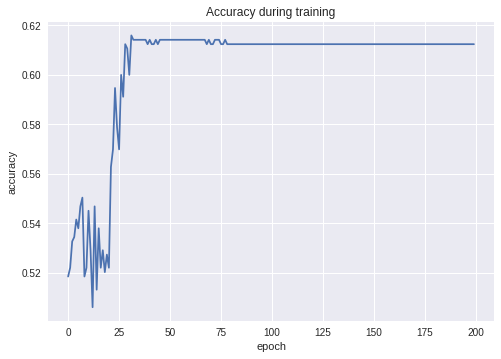

In [51]:
# Plot the accuracy during training
plt.plot(history.history['acc'])
plt.title("Accuracy during training")
plt.ylabel("accuracy")
plt.xlabel("epoch")

Text(0.5,0,'epoch')

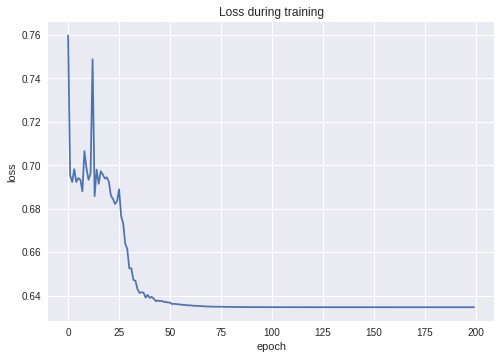

In [52]:
plt.plot(history.history['loss'])
plt.title("Loss during training")
plt.ylabel("loss")
plt.xlabel("epoch")

In [53]:
# Evalute the same model
model.evaluate(x=test_x, y=test_y)


120/120 [==============================] - 7s 58ms/step


[0.6689239184061686, 0.55]